In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math
from sklearn.linear_model import LinearRegression
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
import seaborn as sns

In [2]:
# Constant
VALIDATION_PORTION = 0.2
FEATURES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
TARGET = ['NMHC(GT)', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
LAG_T=[1, 6, 12, 24]
LAG_F=[1, 3, 6, 12, 24]
TARGET_LAG = [t + f"_lag{l}" for t in TARGET for l in LAG_T]
FEATURES_LAG = [f + f"_lag{l}" for f in FEATURES for l in LAG_F]

# Data Preparation

In [3]:
from ucimlrepo import fetch_ucirepo 

In [ ]:
air_quality = fetch_ucirepo(id=360)
origin = air_quality.data.features

In [5]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [6]:
# process data
origin.replace(-200, np.nan, inplace=True)
origin['Datetime'] = origin['Date'] + ' ' + origin['Time']
origin.drop(columns=['Date', 'Time'], inplace=True)
origin['Datetime'] = pd.to_datetime(origin['Datetime'])

In [7]:
origin.set_index('Datetime', inplace=True)
origin = origin.sort_index(axis=1)
origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AH             8991 non-null   float64
 1   C6H6(GT)       8991 non-null   float64
 2   CO(GT)         7674 non-null   float64
 3   NMHC(GT)       914 non-null    float64
 4   NO2(GT)        7715 non-null   float64
 5   NOx(GT)        7718 non-null   float64
 6   PT08.S1(CO)    8991 non-null   float64
 7   PT08.S2(NMHC)  8991 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   PT08.S4(NO2)   8991 non-null   float64
 10  PT08.S5(O3)    8991 non-null   float64
 11  RH             8991 non-null   float64
 12  T              8991 non-null   float64
dtypes: float64(13)
memory usage: 1023.4 KB


In [8]:
origin=origin[['NMHC(GT)', 'CO(GT)', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)',
               'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]

In [9]:
train_dataset = origin[:'2004-12-31 23:00:00']
test_dataset = origin['2005-01-01 00:00:00':]

# missing value handling

In [10]:
def plot_missing_values_heatmap(dataset):
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(dataset.isna(), cbar=False)
# 获取索引
    dates = dataset.index

# 每1024条数据显示一个标签（假设你的数据是每小时一次）
    ax.set_yticks(range(0, len(dates), 1024))
    ax.set_yticklabels([d.strftime('%y-%m-%d') for d in dates[::1024]], fontsize=7)
    plt.title("Missing Values Heatmap (-200 replaced by NaN)")
    plt.show()

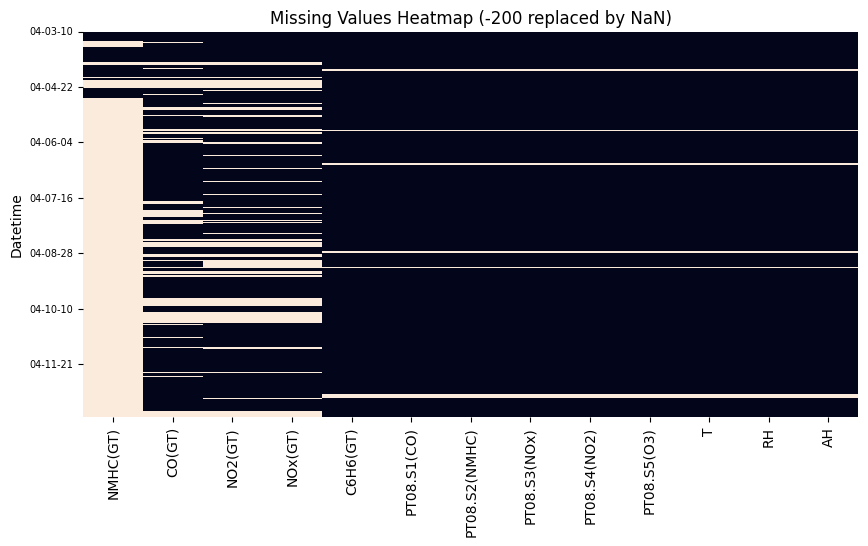

In [11]:
plot_missing_values_heatmap(train_dataset)

We could see that the there are 4 patterns of missing values in the dataset:
1. NMHC(GT) has a lot of missing values;
2. C6H6(GT) has some missing values;
3. NO2(GT) and NOx(GT) have some missing values in the same rows;
4. Other columns have missing values in the same pattern.

Because 'NMHC(GT)' has too many missing values, we will drop this column, and find other ways to improve the model performance later.

In [12]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NMHC(GT)       914 non-null    float64
 1   CO(GT)         5526 non-null   float64
 2   NO2(GT)        5543 non-null   float64
 3   NOx(GT)        5546 non-null   float64
 4   C6H6(GT)       6882 non-null   float64
 5   PT08.S1(CO)    6882 non-null   float64
 6   PT08.S2(NMHC)  6882 non-null   float64
 7   PT08.S3(NOx)   6882 non-null   float64
 8   PT08.S4(NO2)   6882 non-null   float64
 9   PT08.S5(O3)    6882 non-null   float64
 10  T              6882 non-null   float64
 11  RH             6882 non-null   float64
 12  AH             6882 non-null   float64
dtypes: float64(13)
memory usage: 777.7 KB


In [13]:
train_dataset.shape

(7110, 13)

In [ ]:
X_train = train_dataset[FEATURES]
Y_train = train_dataset[TARGET]

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_data = scaler.fit_transform(train_dataset)
train_scaled_df = pd.DataFrame(train_scaled_data, columns=train_dataset.columns, index=train_dataset.index)

In [ ]:
def plot_scatter_each_column_rolling(dataset, window=1):
    for col in dataset.columns:
        plt.figure(figsize=(10, 4))

    # 计算滑动平均
        rolling_values = dataset[col].rolling(window=window, min_periods=1).mean()
        plt.scatter(dataset.index, rolling_values, s=5)
        plt.title(f"Rolling Mean Scatter Plot ({window}) for {col}")
        plt.xlabel("Datetime")
        plt.ylabel(f"{col} (Rolling Mean)")
        plt.tight_layout()
        plt.show()

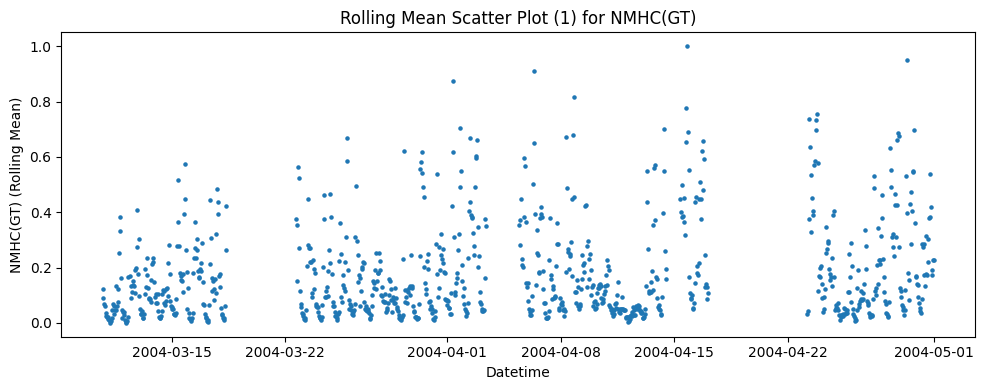

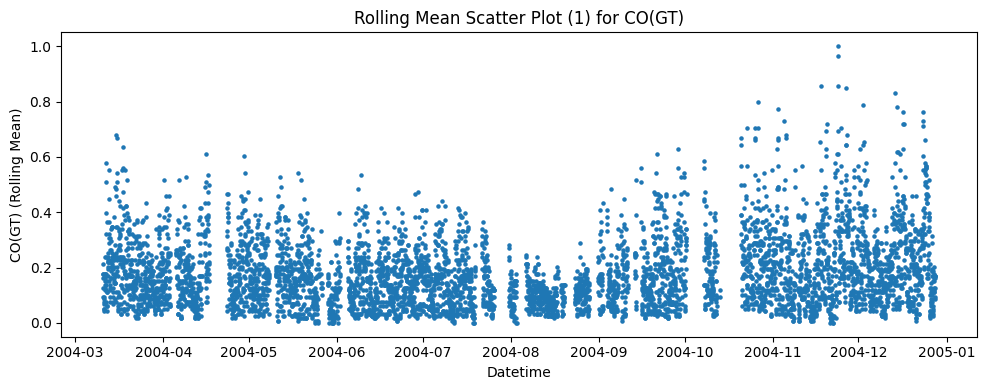

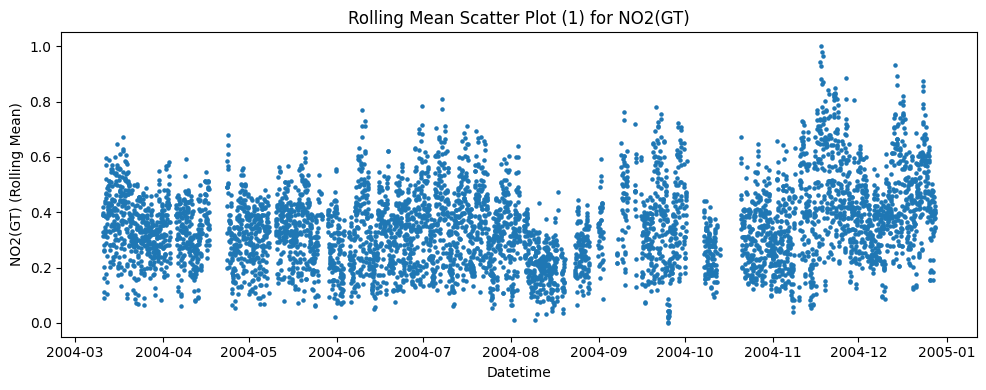

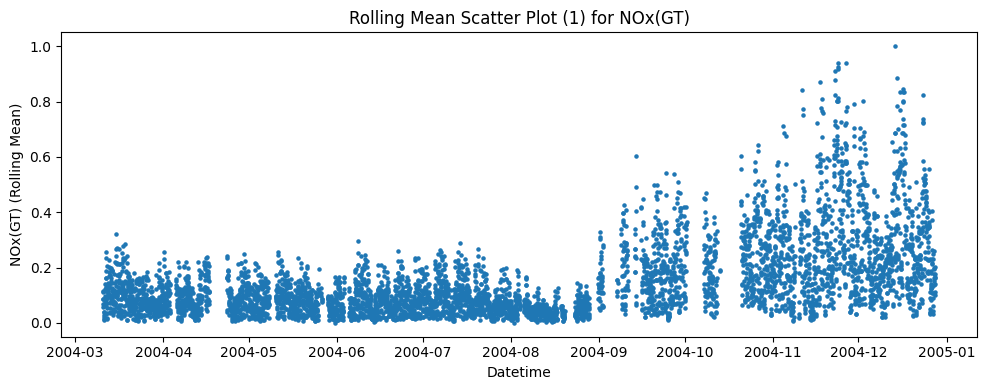

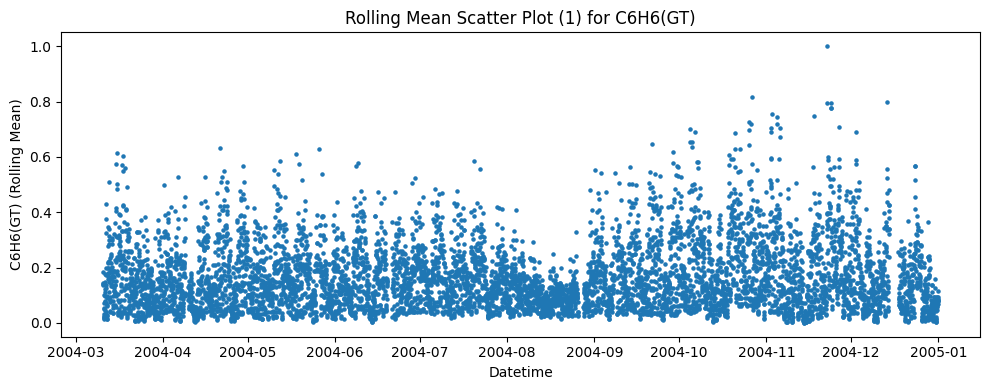

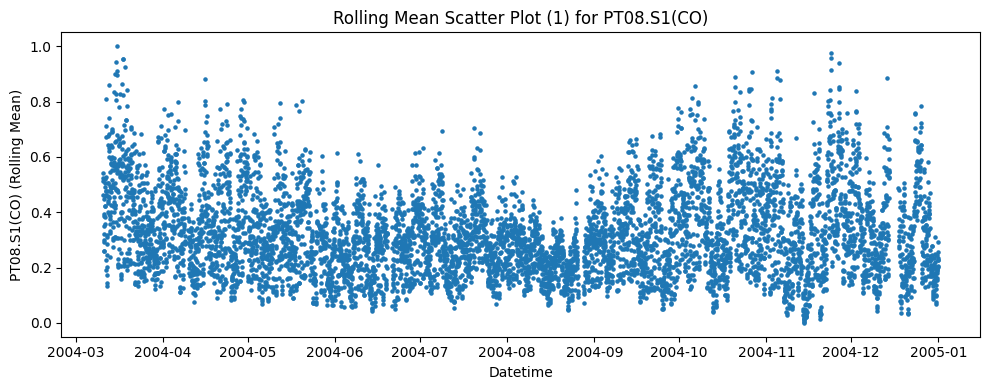

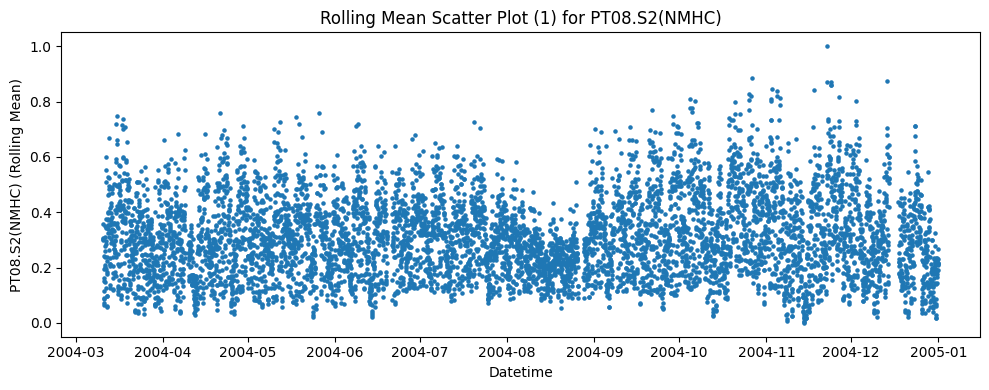

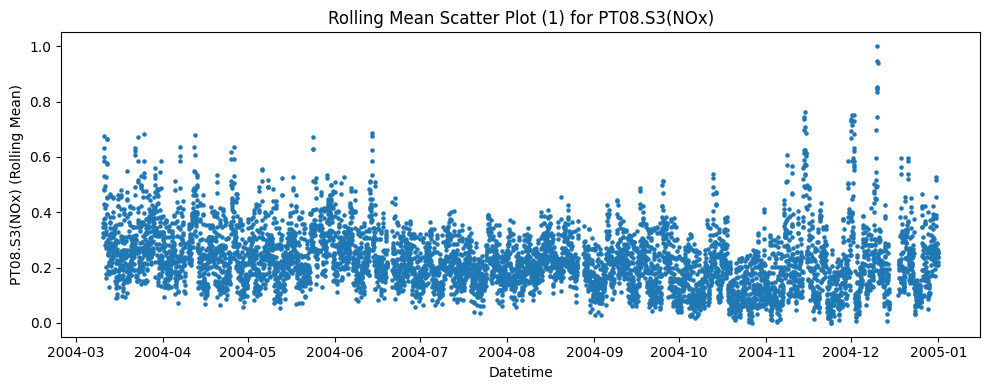

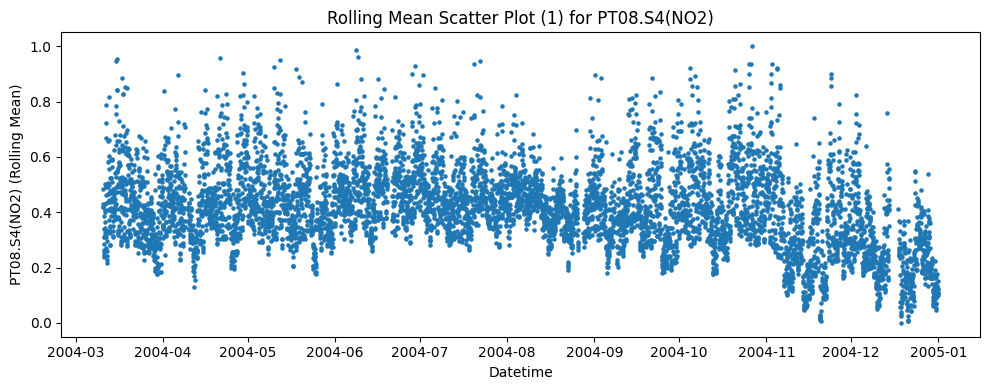

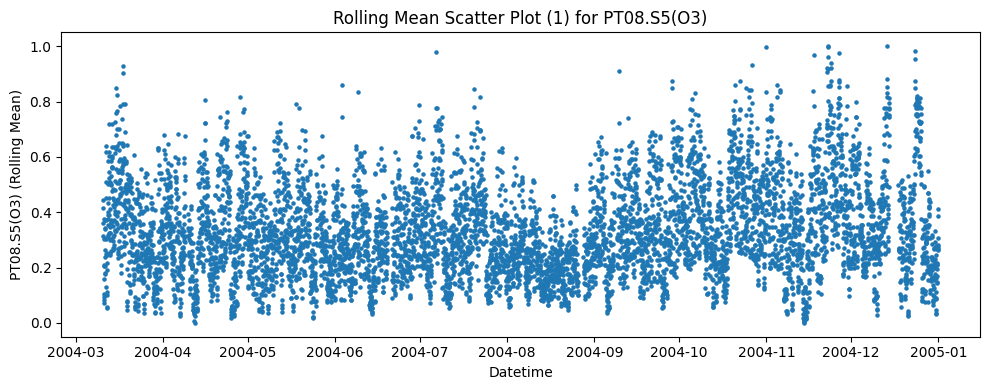

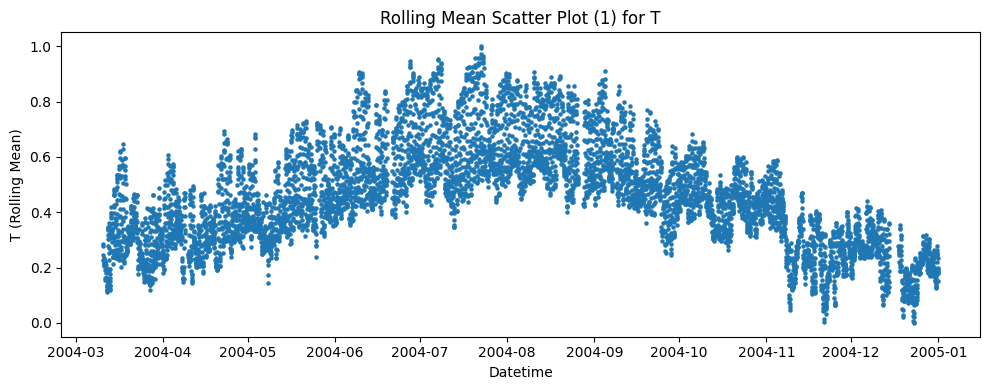

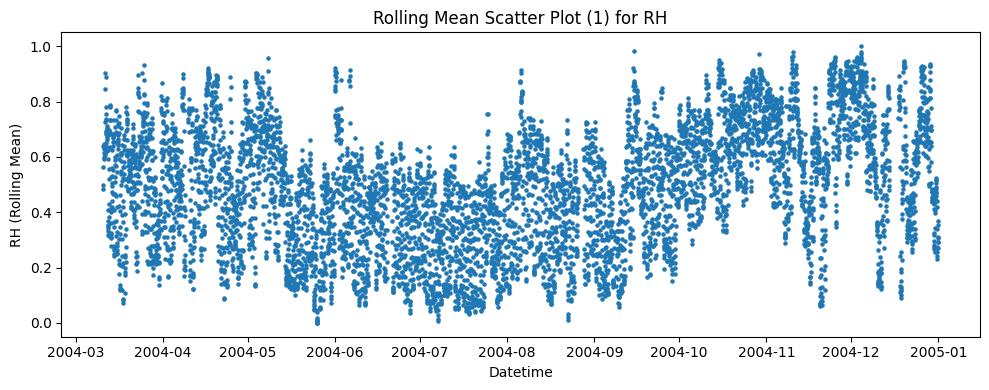

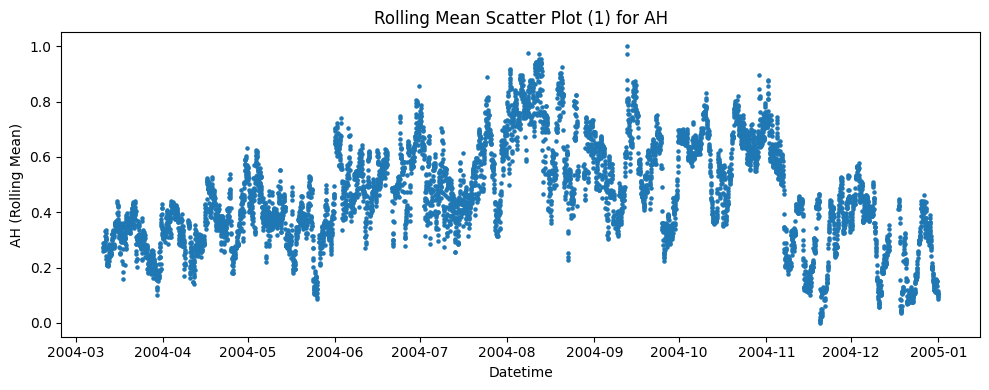

In [20]:
plot_scatter_each_column_rolling(train_scaled_df, window=1)

In [18]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
train_imputed = imputer.fit_transform(train_scaled_df)

In [19]:
train_imputed_df = pd.DataFrame(train_imputed, columns=train_dataset.columns)
train_imputed_df.index = train_dataset.index
train_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7110 non-null   float64
 1   NO2(GT)        7110 non-null   float64
 2   NOx(GT)        7110 non-null   float64
 3   C6H6(GT)       7110 non-null   float64
 4   PT08.S1(CO)    7110 non-null   float64
 5   PT08.S2(NMHC)  7110 non-null   float64
 6   PT08.S3(NOx)   7110 non-null   float64
 7   PT08.S4(NO2)   7110 non-null   float64
 8   PT08.S5(O3)    7110 non-null   float64
 9   T              7110 non-null   float64
 10  RH             7110 non-null   float64
 11  AH             7110 non-null   float64
dtypes: float64(12)
memory usage: 722.1 KB


In [28]:
def plot_scatter_each_column_highlight_missing(dataset, imputed_dataset):
    for col in dataset.columns:
        # 原始的 NaN mask（True = 原来是缺失）
        nan_mask = dataset[col].isna()

        plt.figure(figsize=(12,5))

        # 蓝色点：原本非缺失位置
        plt.scatter(dataset.index[~nan_mask],
                    imputed_dataset[col][~nan_mask],
                    s=12, label='Original values', alpha=0.7)

        # 红色点：原本是缺失 → 用填充值显示
        plt.scatter(dataset.index[nan_mask],
                    imputed_dataset[col][nan_mask],
                    s=12, color='red', label='Imputed values')

        plt.title(f"Imputed values highlighted in red: {col}")
        plt.legend()
        plt.show()

In [ ]:
plot_scatter_each_column_highlight_missing(train_dataset, train_imputed_df)

KNN imputation almost grasp the distribution of the training data, but it seems that it create some outliers in the imputed data.

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_imputed_df.corr(),                   # 相关性矩阵
    annot=True,             # 在格子中显示数值
    fmt=".2f",              # 保留 2 位小数
    cmap="coolwarm",        # 配色方案
    linewidths=0.5,         # 单元格间隔线
    cbar=True               # 显示右侧颜色条
)

plt.title("Correlation Matrix Heatmap For Imputed Training Data", fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_dataset.corr(),                   # 相关性矩阵
    annot=True,             # 在格子中显示数值
    fmt=".2f",              # 保留 2 位小数
    cmap="coolwarm",        # 配色方案
    linewidths=0.5,         # 单元格间隔线
    cbar=True               # 显示右侧颜色条
)

plt.title("Correlation Matrix Heatmap For Original Training Data", fontsize=16)
plt.show()

# Outlier detection and handling

# Feature Engineering

Split features and targets form original dataset and re-handle missing values and outliers for features.

In [23]:
X_train = train_scaled_df.drop(columns=TARGET)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    6882 non-null   float64
 1   PT08.S2(NMHC)  6882 non-null   float64
 2   PT08.S3(NOx)   6882 non-null   float64
 3   PT08.S4(NO2)   6882 non-null   float64
 4   PT08.S5(O3)    6882 non-null   float64
 5   T              6882 non-null   float64
 6   RH             6882 non-null   float64
 7   AH             6882 non-null   float64
dtypes: float64(8)
memory usage: 499.9 KB


In [24]:
Y_train = train_scaled_df[TARGET]
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NMHC(GT)  914 non-null    float64
 1   CO(GT)    5526 non-null   float64
 2   C6H6(GT)  6882 non-null   float64
 3   NOx(GT)   5546 non-null   float64
 4   NO2(GT)   5543 non-null   float64
dtypes: float64(5)
memory usage: 333.3 KB


In [25]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)

In [26]:
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_train_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    7110 non-null   float64
 1   PT08.S2(NMHC)  7110 non-null   float64
 2   PT08.S3(NOx)   7110 non-null   float64
 3   PT08.S4(NO2)   7110 non-null   float64
 4   PT08.S5(O3)    7110 non-null   float64
 5   T              7110 non-null   float64
 6   RH             7110 non-null   float64
 7   AH             7110 non-null   float64
dtypes: float64(8)
memory usage: 499.9 KB


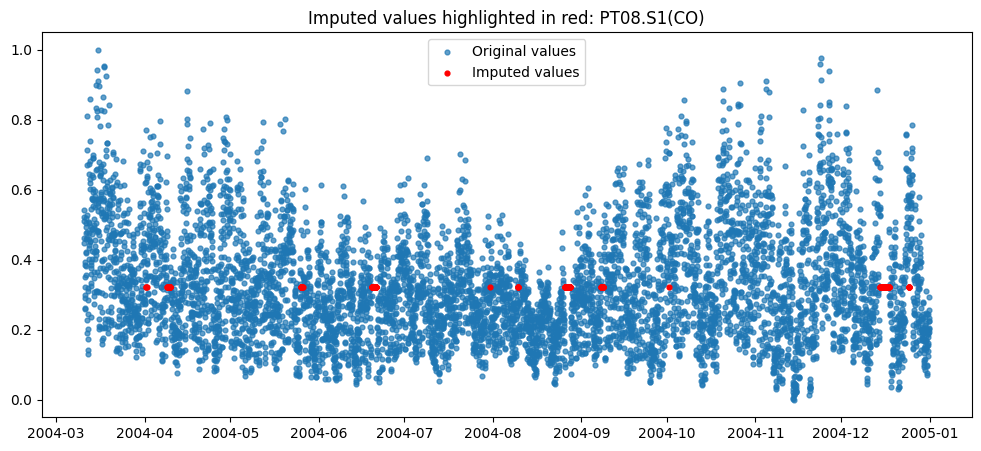

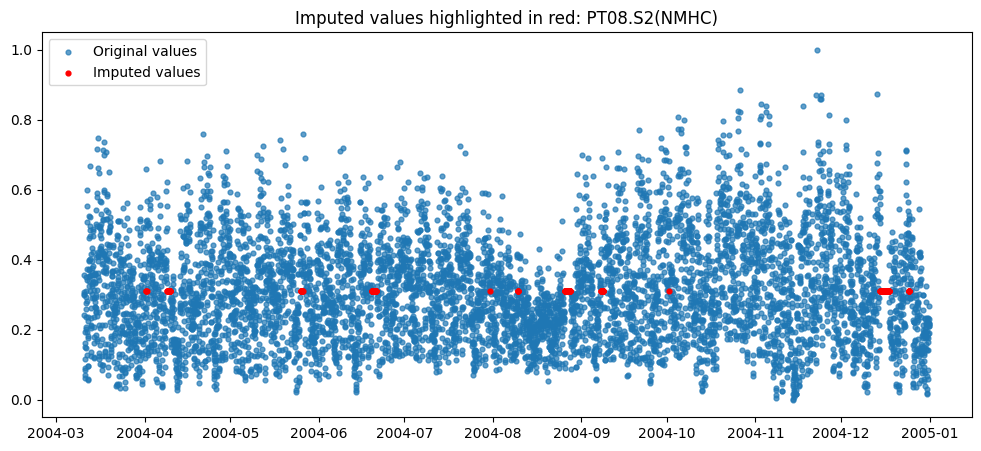

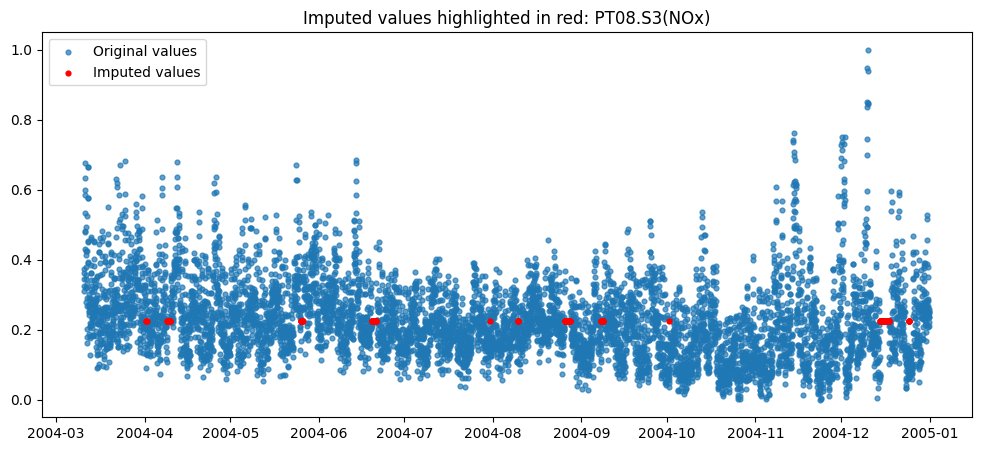

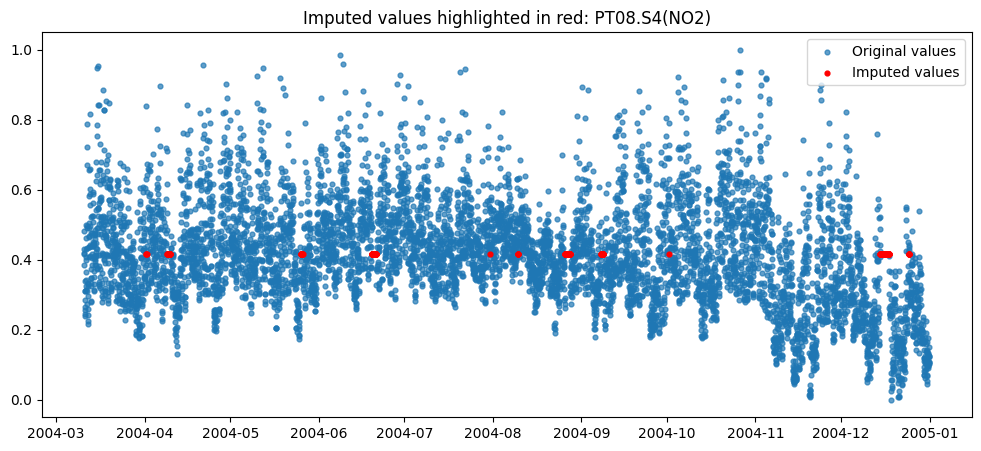

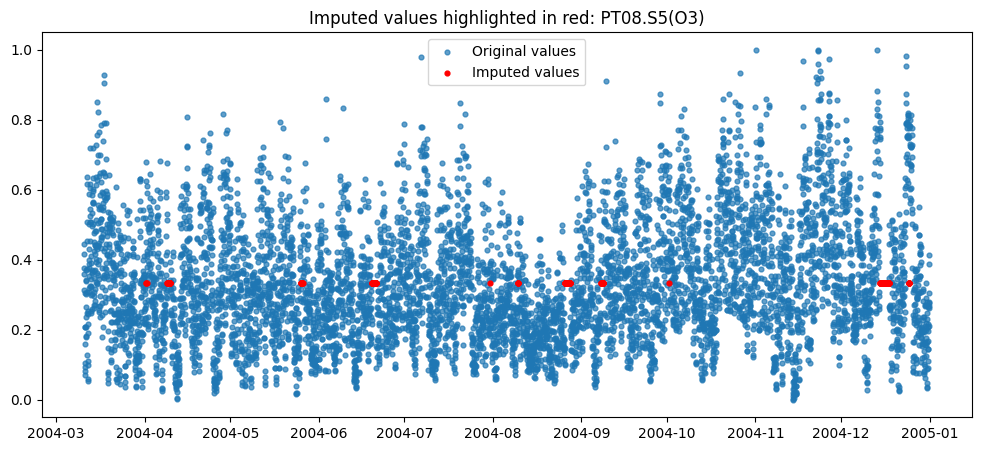

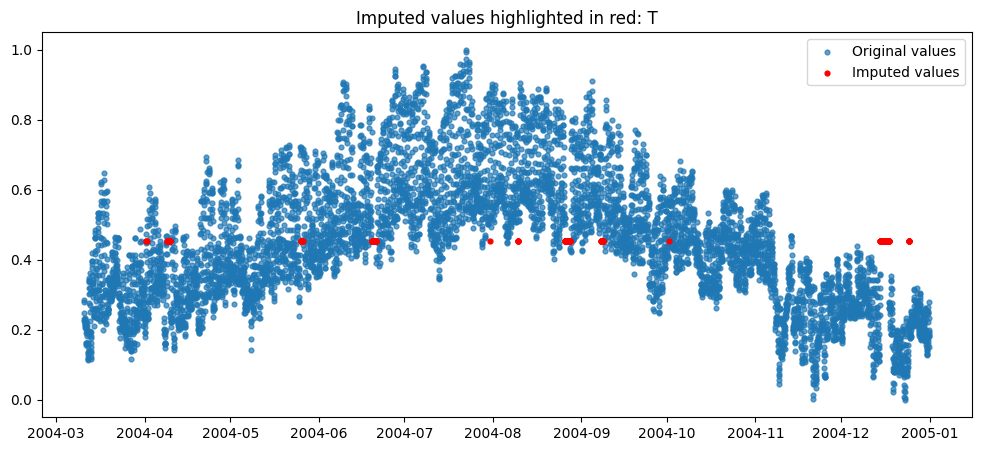

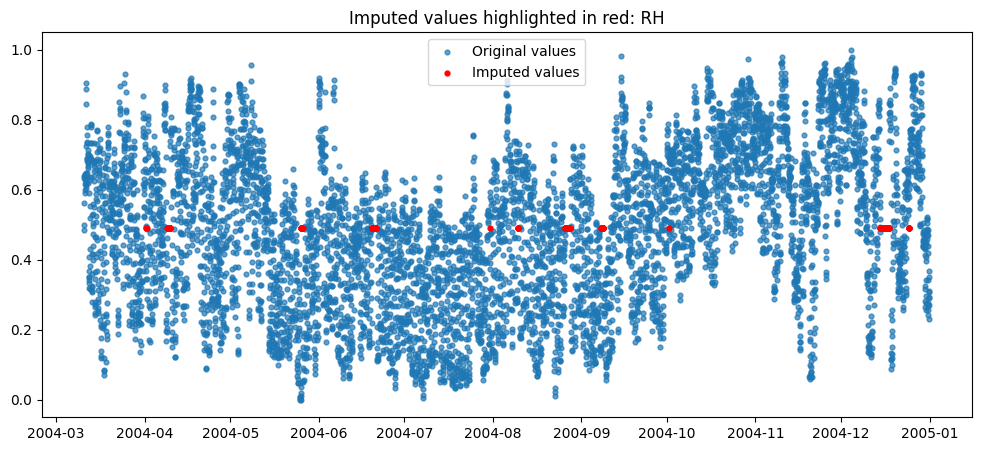

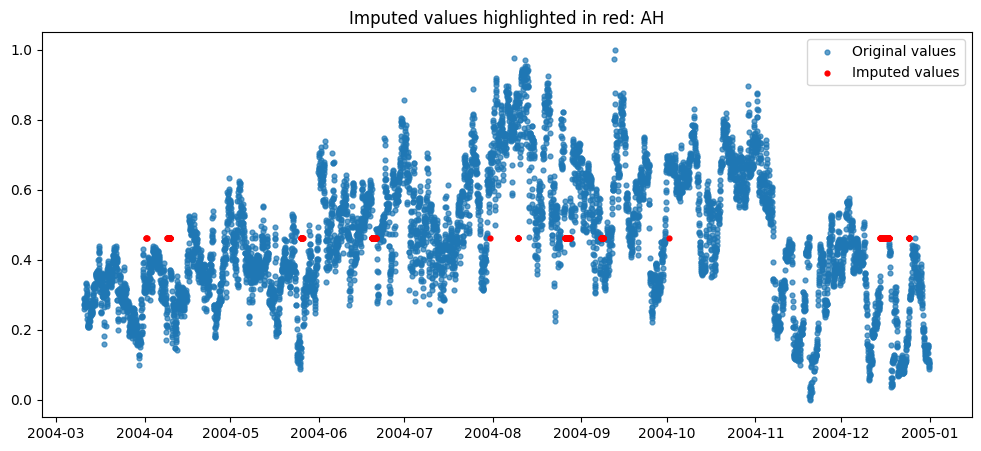

In [29]:
plot_scatter_each_column_highlight_missing(X_train, X_train_imputed_df)

In [3]:
def create_target(dataset: pd.DataFrame, target_columns: list, lag_steps: list) -> pd.DataFrame:
    '''
    Creates lagged target variables in the dataset.
    '''
    dataset_target = dataset.copy()
    for target in target_columns:
        for lag in lag_steps:
            dataset_target[f"{target}_lag{lag}"] = dataset_target[target].shift(-lag)
    return dataset_target

def data_column_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    '''
    delete datetime, create Year and create target lag features
    '''
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Year'] = df['datetime'].dt.year
    df = df.drop(columns=['datetime'])
    df = create_target(df, TARGET, LAG)
    df = df.drop(columns=['NMHC(GT)'])
    return df

In [6]:
def split_data(dataset: pd.DataFrame) -> tuple:
    '''
    Splits the dataset into training and test sets.
    '''
    Y_train = dataset[dataset['Year'] == 2004][TARGET_LAG]
    X_train = dataset[dataset['Year'] == 2004].drop(columns=TARGET_LAG)
    Y_test = dataset[dataset['Year'] == 2005][TARGET_LAG]
    X_test = dataset[dataset['Year'] == 2005].drop(columns=TARGET_LAG)
    return X_train, Y_train, X_test, Y_test

In [7]:
X_train, Y_train, X_test, Y_test = split_data(dataset)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4755 entries, 24 to 6993
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CO(GT)                4755 non-null   float64
 1   PT08.S1(CO)           4755 non-null   float64
 2   C6H6(GT)              4755 non-null   float64
 3   PT08.S2(NMHC)         4755 non-null   float64
 4   NOx(GT)               4755 non-null   float64
 5   PT08.S3(NOx)          4755 non-null   float64
 6   NO2(GT)               4755 non-null   float64
 7   PT08.S4(NO2)          4755 non-null   float64
 8   PT08.S5(O3)           4755 non-null   float64
 9   T                     4755 non-null   float64
 10  RH                    4755 non-null   float64
 11  AH                    4755 non-null   float64
 12  Hour                  4755 non-null   int64  
 13  Weekday               4755 non-null   int64  
 14  Month                 4755 non-null   int64  
 15  T_lag1                475

In [8]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4755 entries, 24 to 6993
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CO(GT)_lag1     4755 non-null   float64
 1   CO(GT)_lag6     4755 non-null   float64
 2   CO(GT)_lag12    4755 non-null   float64
 3   CO(GT)_lag24    4755 non-null   float64
 4   C6H6(GT)_lag1   4755 non-null   float64
 5   C6H6(GT)_lag6   4755 non-null   float64
 6   C6H6(GT)_lag12  4755 non-null   float64
 7   C6H6(GT)_lag24  4755 non-null   float64
 8   NOx(GT)_lag1    4755 non-null   float64
 9   NOx(GT)_lag6    4755 non-null   float64
 10  NOx(GT)_lag12   4755 non-null   float64
 11  NOx(GT)_lag24   4755 non-null   float64
 12  NO2(GT)_lag1    4755 non-null   float64
 13  NO2(GT)_lag6    4755 non-null   float64
 14  NO2(GT)_lag12   4755 non-null   float64
 15  NO2(GT)_lag24   4755 non-null   float64
dtypes: float64(16)
memory usage: 631.5 KB


In [9]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1910 entries, 7111 to 9332
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CO(GT)                1910 non-null   float64
 1   PT08.S1(CO)           1910 non-null   float64
 2   C6H6(GT)              1910 non-null   float64
 3   PT08.S2(NMHC)         1910 non-null   float64
 4   NOx(GT)               1910 non-null   float64
 5   PT08.S3(NOx)          1910 non-null   float64
 6   NO2(GT)               1910 non-null   float64
 7   PT08.S4(NO2)          1910 non-null   float64
 8   PT08.S5(O3)           1910 non-null   float64
 9   T                     1910 non-null   float64
 10  RH                    1910 non-null   float64
 11  AH                    1910 non-null   float64
 12  Hour                  1910 non-null   int64  
 13  Weekday               1910 non-null   int64  
 14  Month                 1910 non-null   int64  
 15  T_lag1                1

In [10]:
Y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1910 entries, 7111 to 9332
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CO(GT)_lag1     1910 non-null   float64
 1   CO(GT)_lag6     1910 non-null   float64
 2   CO(GT)_lag12    1910 non-null   float64
 3   CO(GT)_lag24    1910 non-null   float64
 4   C6H6(GT)_lag1   1910 non-null   float64
 5   C6H6(GT)_lag6   1910 non-null   float64
 6   C6H6(GT)_lag12  1910 non-null   float64
 7   C6H6(GT)_lag24  1910 non-null   float64
 8   NOx(GT)_lag1    1910 non-null   float64
 9   NOx(GT)_lag6    1910 non-null   float64
 10  NOx(GT)_lag12   1910 non-null   float64
 11  NOx(GT)_lag24   1910 non-null   float64
 12  NO2(GT)_lag1    1910 non-null   float64
 13  NO2(GT)_lag6    1910 non-null   float64
 14  NO2(GT)_lag12   1910 non-null   float64
 15  NO2(GT)_lag24   1910 non-null   float64
dtypes: float64(16)
memory usage: 253.7 KB


In [11]:
'''
Define neural network model using PyTorch
'''

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lr=1e-3, hidden=64, epochs=20):
        self.lr = lr
        self.hidden = hidden
        self.epochs = epochs
        self.model = None
    
    def _build_model(self, input_dim, output_dim=1):
        return nn.Sequential(
            nn.Linear(input_dim, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, output_dim)
        )

    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32).view(-1, Y.shape[1])

        self.model = self._build_model(X.shape[1], output_dim=Y.shape[1])
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        for _ in range(self.epochs):
            optimizer.zero_grad()
            pred = self.model(X)
            loss = criterion(pred, Y)
            loss.backward()
            optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            pred = self.model(X).numpy()
        return pred

In [12]:
# Predefine attributes
model = TorchRegressor()

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  
    ('model', model)
])

hyperspace = {
    "model__lr": Real(1e-4, 1e-1, prior="log-uniform"),
    "model__hidden": Integer(16, 256),
    "model__epochs": Integer(5, 50)
}

ps = PredefinedSplit(
    test_fold=np.concatenate([
        -np.ones(int(len(X_train)*(1-VALIDATION_PORTION))),   # train
        np.zeros(int(len(X_train)*VALIDATION_PORTION))        # validation
    ])
)

opt = BayesSearchCV(
    estimator=pipeline,  
    search_spaces=hyperspace,
    cv=ps,
    n_iter=32,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)
opt.fit(X_train.to_numpy(), Y_train.to_numpy())

best_model = opt.best_estimator_
best_params = opt.best_params_

Y_pred = best_model.predict(X_test.to_numpy())
metrics = {}
metrics['rmse'] = np.sqrt(np.mean((Y_pred - Y_test.to_numpy())**2))

c:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(50), np.int64(256), 0.1] before, using random point [np.int64(6), np.int64(41), 0.00010779525638223167]
  warnings.warn(
c:\LocalFile\9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


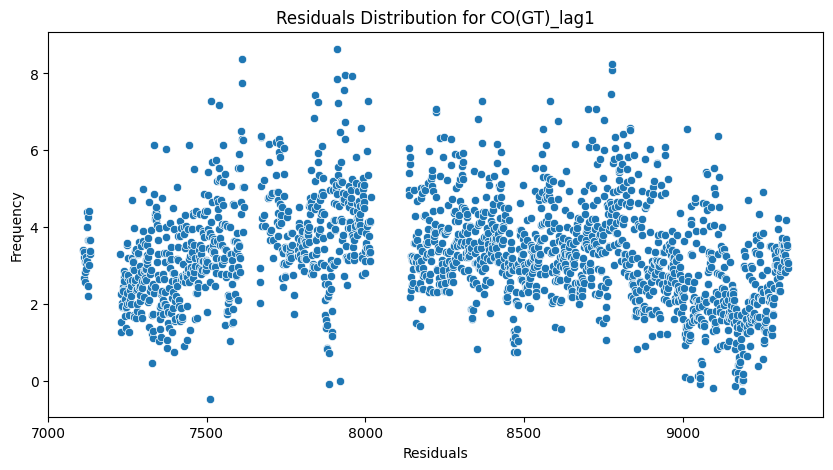

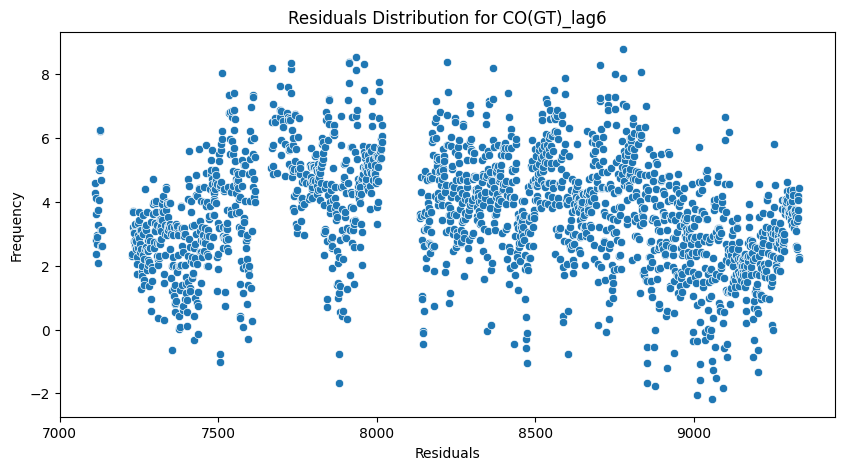

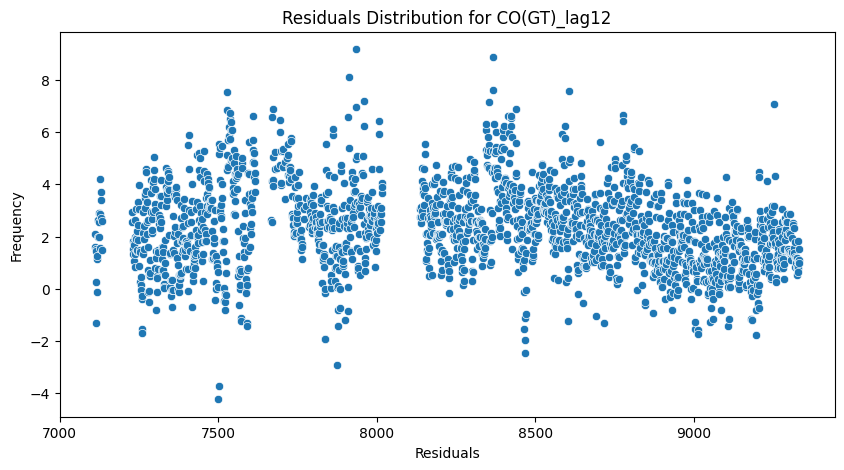

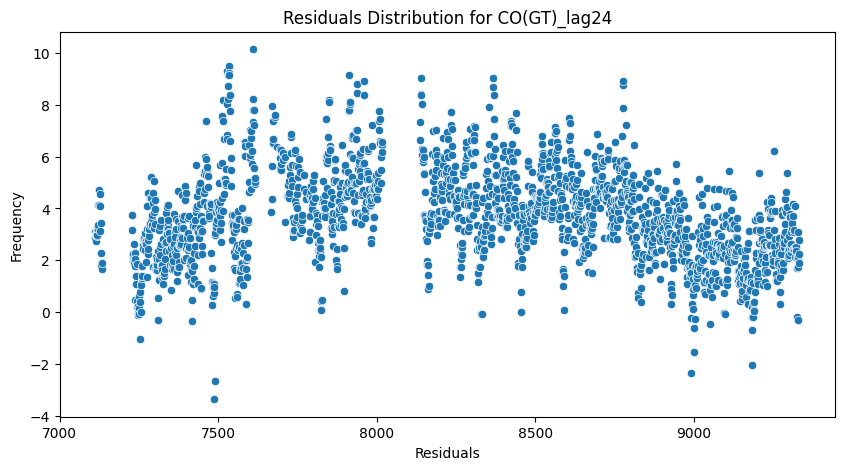

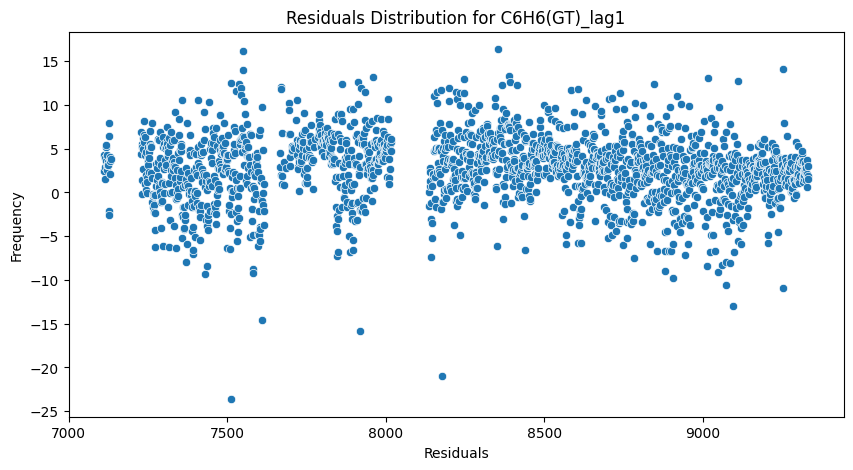

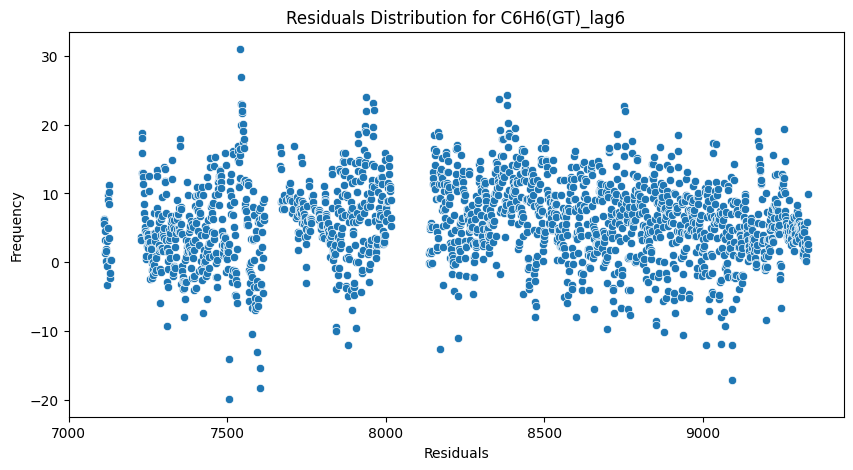

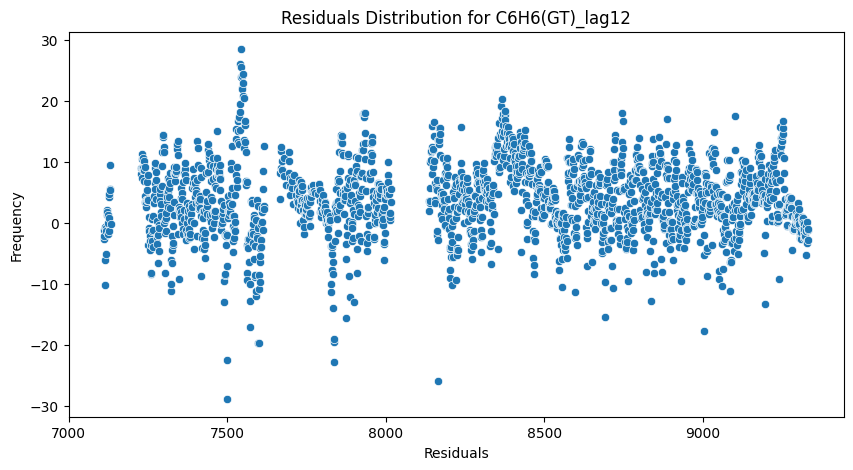

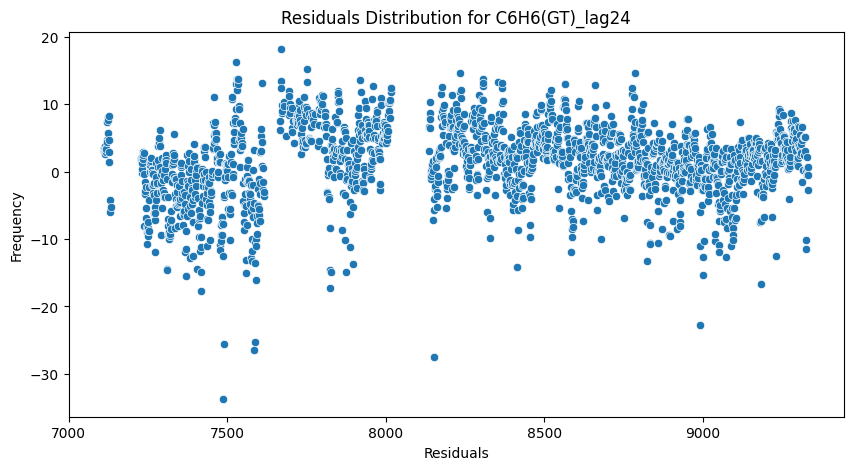

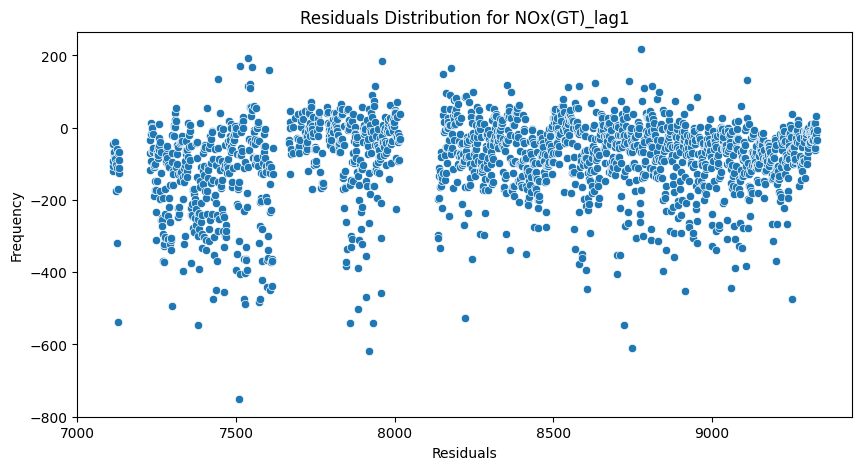

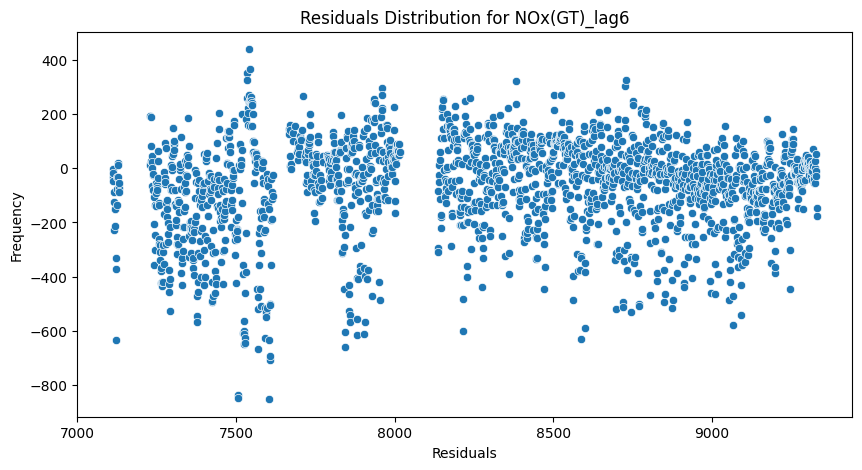

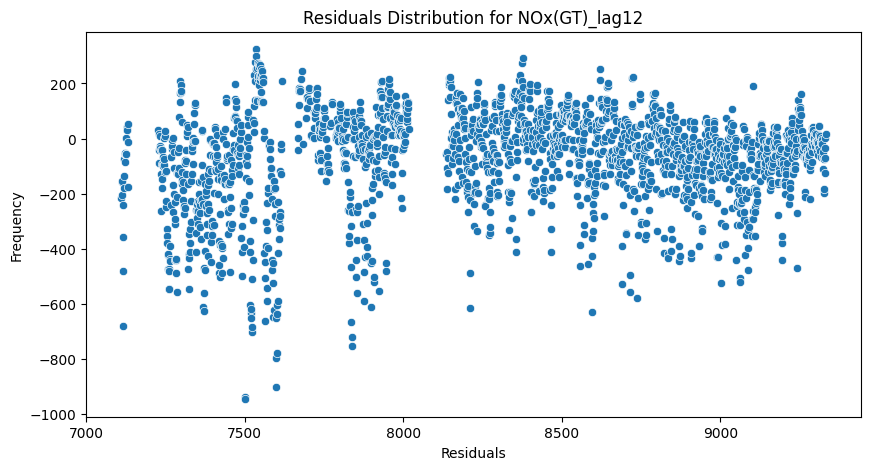

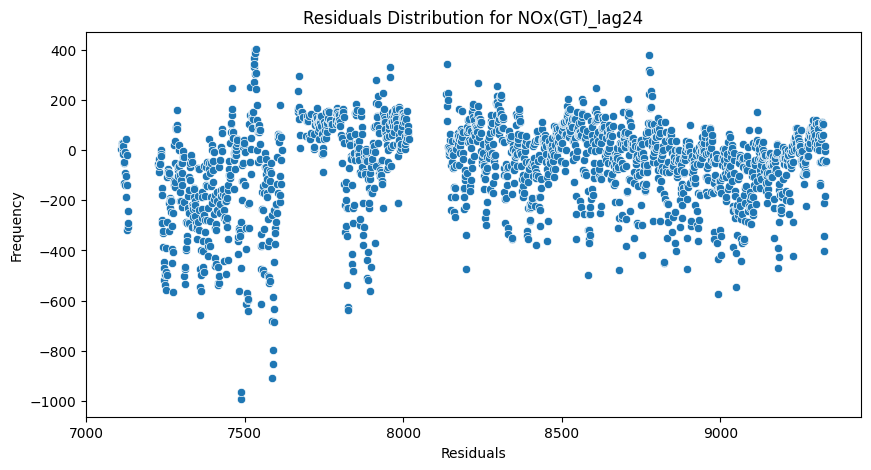

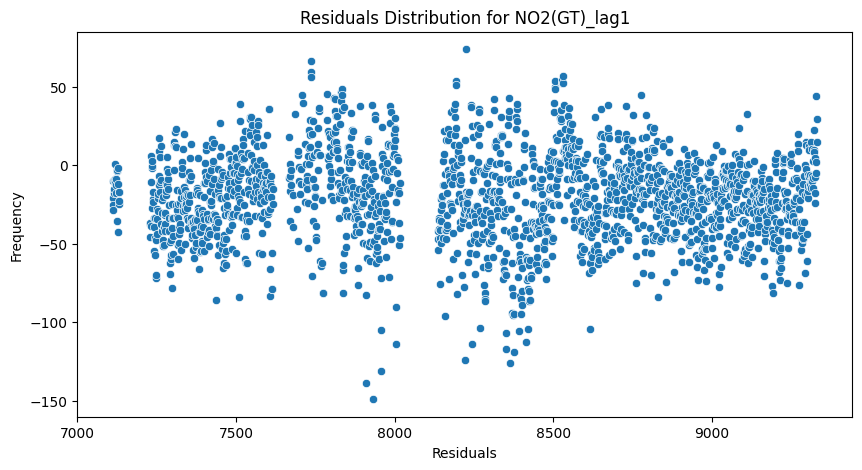

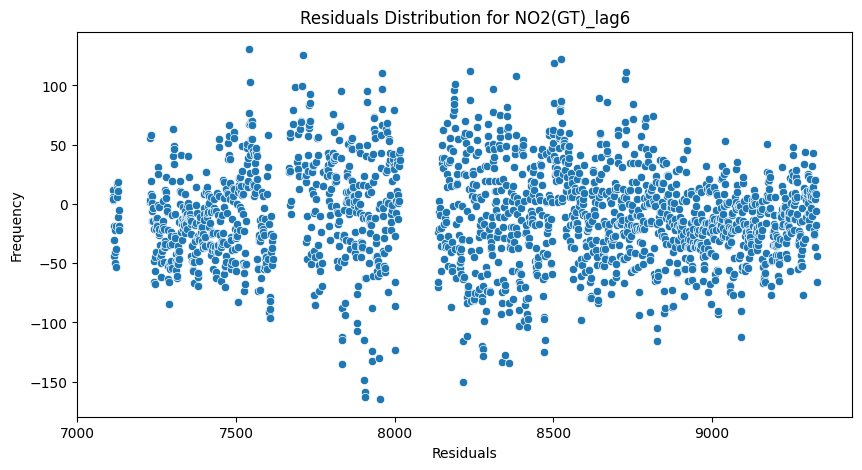

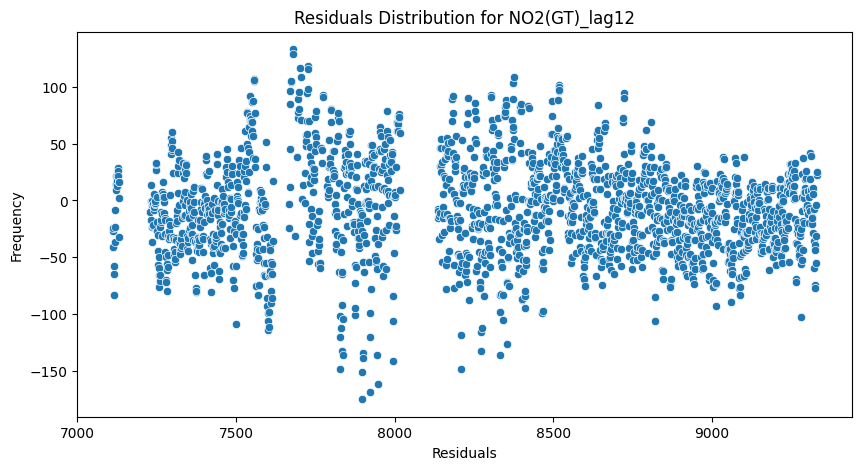

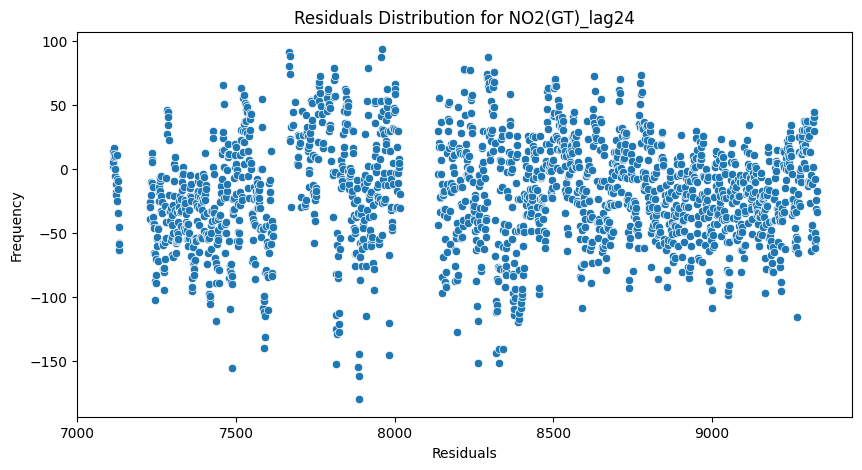

In [20]:
residuals=pd.DataFrame(Y_pred-Y_test)
for i, col in enumerate(Y_test.columns):
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=residuals.index, y=residuals.iloc[:, i])
    plt.title(f'Residuals Distribution for {col}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

In [82]:
def plot_rmse(ax, rmses: pd.Series):
    '''
    Plots RMSE over iterations.
    '''
    ax.scatter(rmses.index, rmses.values, marker='o')
    ax.set_xlabel('models')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE over models')

def plot_metrics(metrics: dict):
    '''
    Plots the metrics.
    '''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plot_rmse(ax, pd.Series(metrics['rmse']))
    plt.show()
